## Quality Control

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation
# Data retrieval
import pooch

In [2]:
adata = sc.read("Downloads/Data_Brain/Brain_Combined.h5ad")

/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

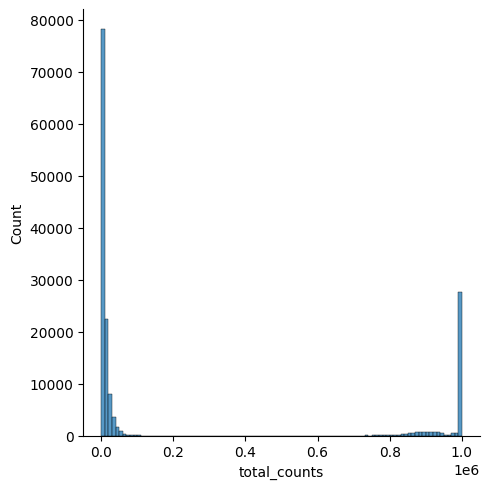

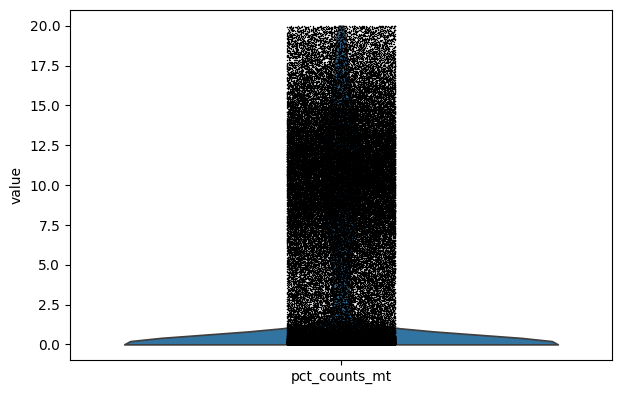

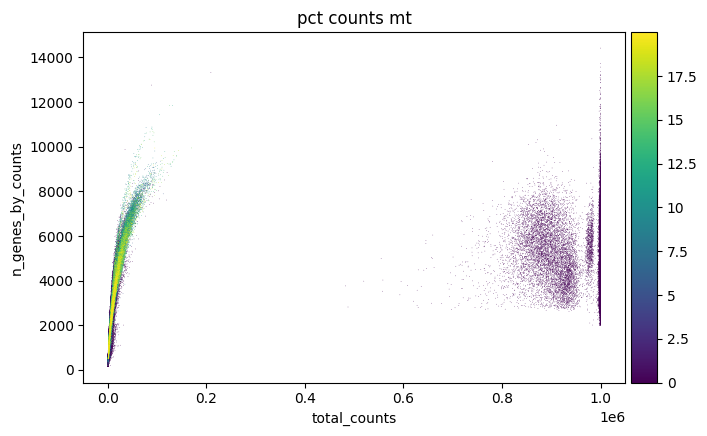

In [5]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
# Remove cells with very low or very high total counts
adata = adata[adata.obs.total_counts > 500, :]      # Lower bound (adjust if needed)
adata = adata[adata.obs.total_counts < 100000, :]   # Upper bound — you can try 200k or 250k too

# Optional: filter cells with too few or too many genes
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :]

# Optional: filter cells with too much mitochondrial content
adata = adata[adata.obs.pct_counts_mt < 5, :]


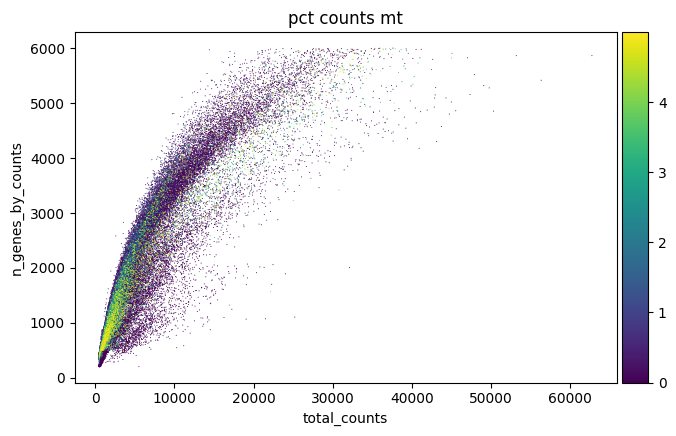

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [9]:
print(adata.obs.columns)


Index(['cell_name', 'sample', 'patient', 'cell_type', 'cell_subtype',
       'complexity', 'cell_cycle_phase', 'source', 'cancer_type', 'technology',
       'n_cells', 'age', 'disease_extent', 'sex', 'sample_primary_met',
       'treated_naive', 'site', 'study', 'category', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'],
      dtype='object')


In [10]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_50_genes", 5)
)
adata.obs.outlier.value_counts()

/tmp/ipykernel_15769/702250040.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["outlier"] = (
/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


outlier
False    56334
True      1492
Name: count, dtype: int64

In [11]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 20
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    39870
True     17956
Name: count, dtype: int64

In [12]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 57826
Number of cells after filtering of low quality cells: 38617


/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


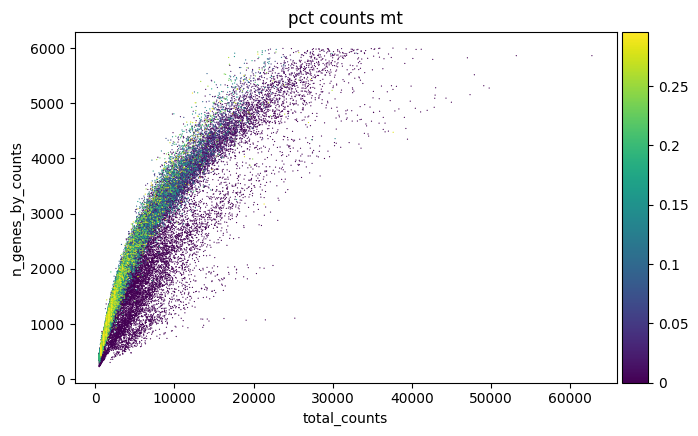

In [13]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [19]:
adata.write("Downloads/Data_Brain/Brain_quality_control.h5ad")

In [ ]:
##SCVI integration

In [31]:
adata = sc.read("Downloads/Data_Brain/Brain_quality_control.h5ad")

/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
!pip install scvi-tools


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 KB 1.3 MB/s eta 0:00:000:00:010:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 KB 2.0 MB/s eta 0:00:001.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 KB 3.0 MB/s eta 0:00:003.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 KB 2.0 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 756.6 kB/s eta 0:00:00m eta 0:00:010:00:17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 KB 1.5 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [17]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

In [32]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [33]:
sc.pp.filter_genes(adata, min_counts=3)

/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata  # freeze the state in `.raw`

In [26]:
adata.obs['study']

666      Choudhury2022_Brain
14785    Choudhury2022_Brain
14790    Choudhury2022_Brain
15129    Choudhury2022_Brain
15238    Choudhury2022_Brain
                ...         
23788         Yuan2018_Brain
23789         Yuan2018_Brain
23790         Yuan2018_Brain
23791         Yuan2018_Brain
23792         Yuan2018_Brain
Name: study, Length: 38617, dtype: category
Categories (4, object): ['Choudhury2022_Brain', 'Neftel2019_Brain', 'Wang2019_Brain', 'Yuan2018_Brain']

In [28]:
!pip install --user scikit-misc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 KB 779.8 kB/s eta 0:00:00 kB/s eta 0:00:01:01


In [30]:
print(adata.layers.keys())


KeysView(Layers with keys: counts)


In [36]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    flavor="cell_ranger",
    batch_key="study",
)


/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [40]:
adata.obs.columns

Index(['cell_name', 'sample', 'patient', 'cell_type', 'cell_subtype',
       'complexity', 'cell_cycle_phase', 'source', 'cancer_type', 'technology',
       'n_cells', 'age', 'disease_extent', 'sex', 'sample_primary_met',
       'treated_naive', 'site', 'study', 'category', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier',
       'mt_outlier', '_scvi_batch', '_scvi_labels'],
      dtype='object')

In [38]:
adata.obs

,cell_name,sample,patient,cell_type,cell_subtype,complexity,cell_cycle_phase,source,cancer_type,technology,...,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,_scvi_batch,_scvi_labels
666,MSC1_CACAGGCGTAACGCGA,MSC1,1,Malignant,G1 phase meningioma cells,792,NaN,Meningioma,Meningioma,10x,...,250.0,5.525453,17.313021,0.0,0.000000,0.000000,False,False,0,0
14785,MSC4-Dura_AGTGACTGTTAGGCCC,MSC4-Dura,4,Pericyte,Pericytes,1043,Not cycling,Dura,Meningioma,10x,...,799.0,6.684612,30.507828,0.0,0.000000,0.000000,False,False,0,0
14790,MSC4-Dura_ATACCTTAGCGTGAGT,MSC4-Dura,4,Pericyte,Pericytes,994,NaN,Dura,Meningioma,10x,...,493.0,6.202536,23.134678,0.0,0.000000,0.000000,False,False,0,0
15129,MSC4-Dura_CTGGCAGAGGTTCCAT,MSC4-Dura,4,Pericyte,Pericytes,1277,Not cycling,Dura,Meningioma,10x,...,689.0,6.536692,24.837780,1.0,0.693147,0.036049,False,False,0,0
15238,MSC4-Dura_GCATGATCACAAGCTT,MSC4-Dura,4,T_cell,CD4 T cells,1469,Not cycling,Dura,Meningioma,10x,...,1392.0,7.239215,33.574532,2.0,1.098612,0.048239,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23788,23789,PJ048,PJ048,Malignant,NaN,361,NaN,NaN,Glioblastoma,Microwell array-based platform,...,151.0,5.023880,30.079681,0.0,0.000000,0.000000,False,False,0,0
23789,23790,PJ048,PJ048,Malignant,NaN,348,NaN,NaN,Glioblastoma,Microwell array-based platform,...,151.0,5.023880,30.079681,0.0,0.000000,0.000000,False,False,0,0
23790,23791,PJ048,PJ048,Malignant,NaN,413,NaN,NaN,Glioblastoma,Microwell array-based platform,...,51.0,3.951244,10.159363,1.0,0.693147,0.199203,False,False,0,0
23791,23792,PJ048,PJ048,Malignant,NaN,370,NaN,NaN,Glioblastoma,Microwell array-based platform,...,168.0,5.129899,33.466137,0.0,0.000000,0.000000,False,False,0,0


In [41]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["study", "sample"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"],
)

/home/ubuntu/.local/lib/python3.10/site-packages/scvi/data/fields/_arraylike_field.py:421: UserWarning: Category 10 in adata.obs['sample'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(df, key, key, categorical_dtype=categorical_dtype)


### Creating and training a model

In [42]:
model = scvi.model.SCVI(adata)

In [43]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [44]:
model.train()

/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training:   0%|          | 0/207 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserW

In [47]:
save_dir = "./Downloads/Data_Brain"
model_dir = os.path.join(save_dir, "scvi_model")
model.save(model_dir, overwrite=True)

In [48]:
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File ./Downloads/Data_Brain/scvi_model/model.pt already downloaded                                        


/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/.local/lib/python3.10/site-packages/scvi/data/fields/_arraylike_field.py:421: UserWarning: Category 10 in adata.obs['sample'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(df, key, key, categorical_dtype=categorical_dtype)


In [51]:
adata.X.max()

np.float32(8.097759)

In [52]:
adata.layers

Layers with keys: counts

In [81]:
!pip install SCVI-tools

Defaulting to user installation because normal site-packages is not writeable


## Clustering and Visuaalization

### Without batch correction

In [53]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [55]:
print (adata.obs.columns)

Index(['cell_name', 'sample', 'patient', 'cell_type', 'cell_subtype',
       'complexity', 'cell_cycle_phase', 'source', 'cancer_type', 'technology',
       'n_cells', 'age', 'disease_extent', 'sex', 'sample_primary_met',
       'treated_naive', 'site', 'study', 'category', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier',
       'mt_outlier', '_scvi_batch', '_scvi_labels'],
      dtype='object')


In [70]:
adata.obs['cell_type'].value_counts()

cell_type
Malignant          26978
Myeloid             3219
Macrophage          3080
Oligodendrocyte     3049
Fibroblast           496
Endothelial          407
Pericyte             299
T_cell               165
Astrocyte             26
Monocyte               1
Name: count, dtype: int64

In [73]:
adata.obs['cancer_type'].value_counts()

cancer_type
Glioblastoma    37513
Meningioma         56
Name: count, dtype: int64

In [74]:
adata.obs['site'].value_counts()

site
Brain                   12291
left temporal            6740
Right frontal            3657
right frontal            3581
Right temporal           3168
right parietal           2924
Left temporal            1800
Left frontal             1781
Right frontotemporal     1612
nan                      1007
brain                      56
Name: count, dtype: int64

In [77]:
adata.obs['technology'].value_counts()

technology
Microwell array-based platform    13245
10X                               13025
10x                               12347
Name: count, dtype: int64

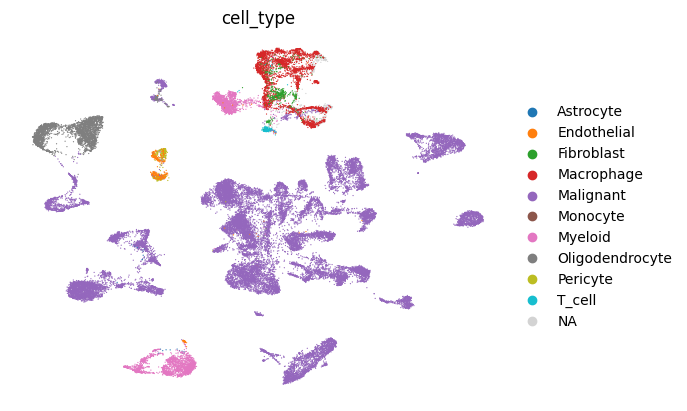

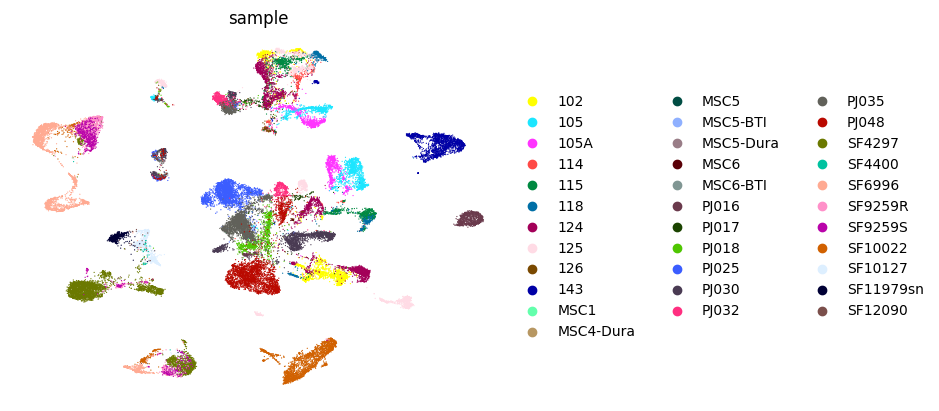

In [79]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["sample"],
    frameon=False,
)

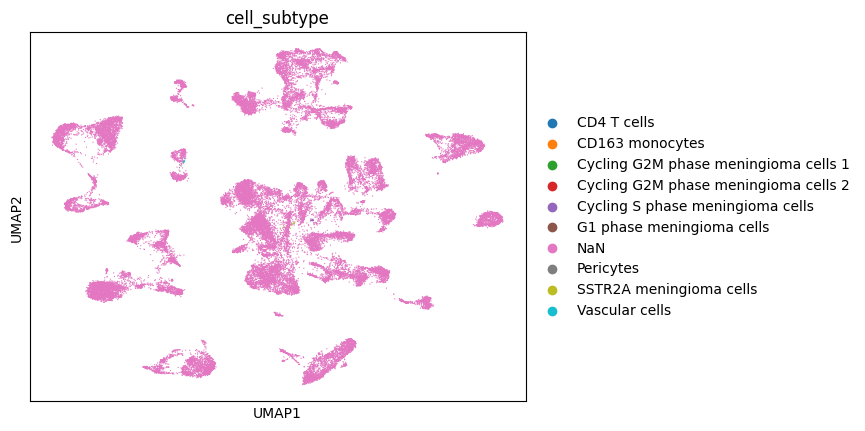

In [64]:
sc.pl.umap(adata, color=["cell_subtype"])

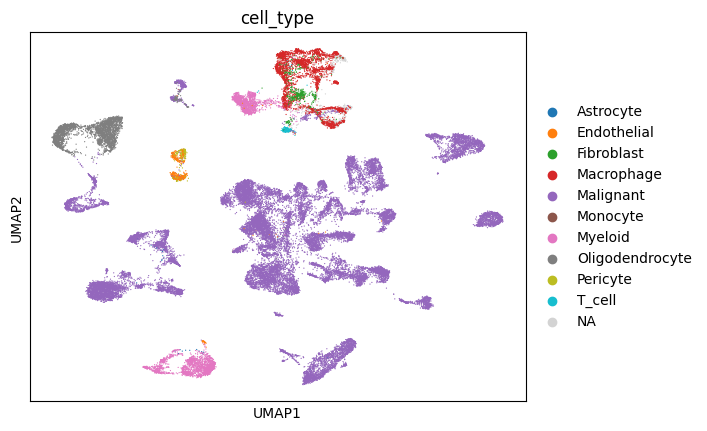

In [67]:
sc.pl.umap(adata, color=["cell_type"])

### with batch correction

In [85]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(38617, 10)

In [86]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

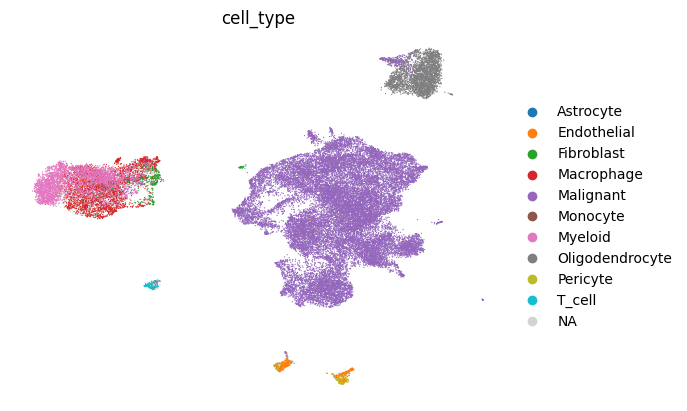

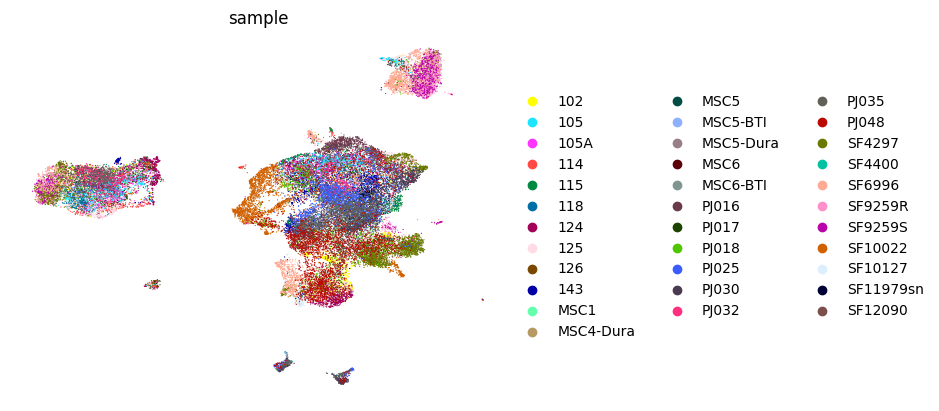

In [87]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["sample"],
    frameon=False,
)